In [28]:
import os

In [37]:
os.chdir('C:\\Users\\LENOVO\\credit_scoring')

In [38]:
%pwd

'C:\\Users\\LENOVO\\credit_scoring'

# Data Preprocessing

In [87]:
#Preprocessing Data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and normalize JSON
df = pd.read_json(file_path)

# Normalize nested fields
df = pd.json_normalize(df.to_dict(orient='records'))

print(f"Total records: {len(df)}")
print("Columns:\n", df.columns.tolist())
print("Unique wallets:", df['userWallet'].nunique())

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Normalize amounts (some assets use 1e6 scale, some 1e18 – rough normalization here)
df['amount'] = pd.to_numeric(df['actionData.amount'], errors='coerce')
df['amount'] = df['amount'] / 1e18

# Rename for easier access
df.rename(columns={
    'actionData.type': 'actionType',
    'actionData.assetPriceUSD': 'assetPriceUSD',
    'actionData.assetSymbol': 'assetSymbol'
}, inplace=True)

# Convert asset price to float
df['assetPriceUSD'] = pd.to_numeric(df['assetPriceUSD'], errors='coerce')

# Final shape
df[['userWallet', 'timestamp', 'action', 'actionType', 'amount', 'assetSymbol', 'assetPriceUSD']].head()


Total records: 100000
Columns:
 ['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type', 'actionData.amount', 'actionData.assetSymbol', 'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId', 'createdAt.$date', 'updatedAt.$date', 'actionData.toId', 'actionData.borrowRateMode', 'actionData.borrowRate', 'actionData.variableTokenDebt', 'actionData.stableTokenDebt', 'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId', 'actionData.liquidatorId', 'actionData.collateralAmount', 'actionData.collateralAssetPriceUSD', 'actionData.principalAmount', 'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId', 'actionData.collateralReserveSymbol', 'actionData.principalReserveId', 'actionData.principalReserveSymbol']
Unique wallets: 3497


,userWallet,timestamp,action,actionType,amount,assetSymbol,assetPriceUSD
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26,deposit,Deposit,2.000000e-09,USDC,0.993832
1,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53,deposit,Deposit,1.450000e+02,WMATIC,1.970307
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33,deposit,Deposit,1.000000e-03,WMATIC,0.922377
3,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31 23:15:18,deposit,Deposit,4.000000e-03,WMATIC,1.057483
4,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:25:07,redeemunderlying,RedeemUnderlying,5.015480e-13,USDC,1.002130


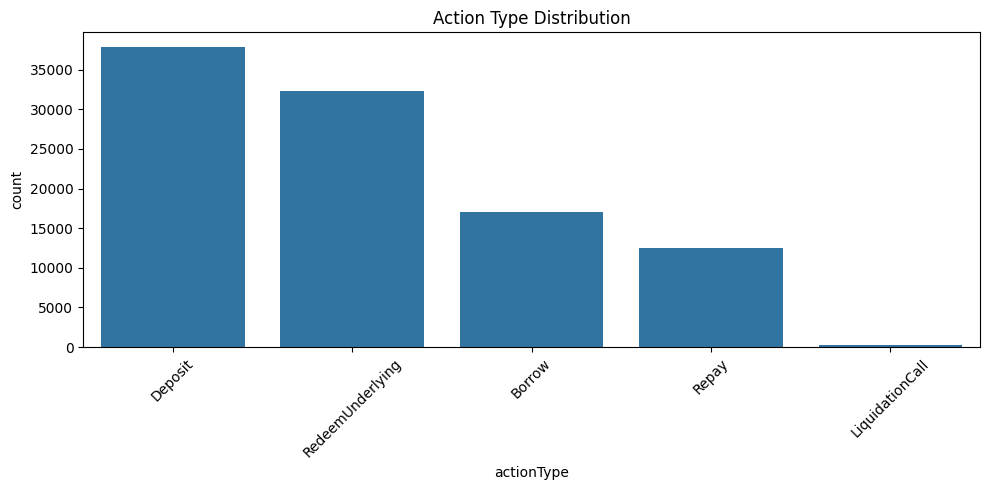

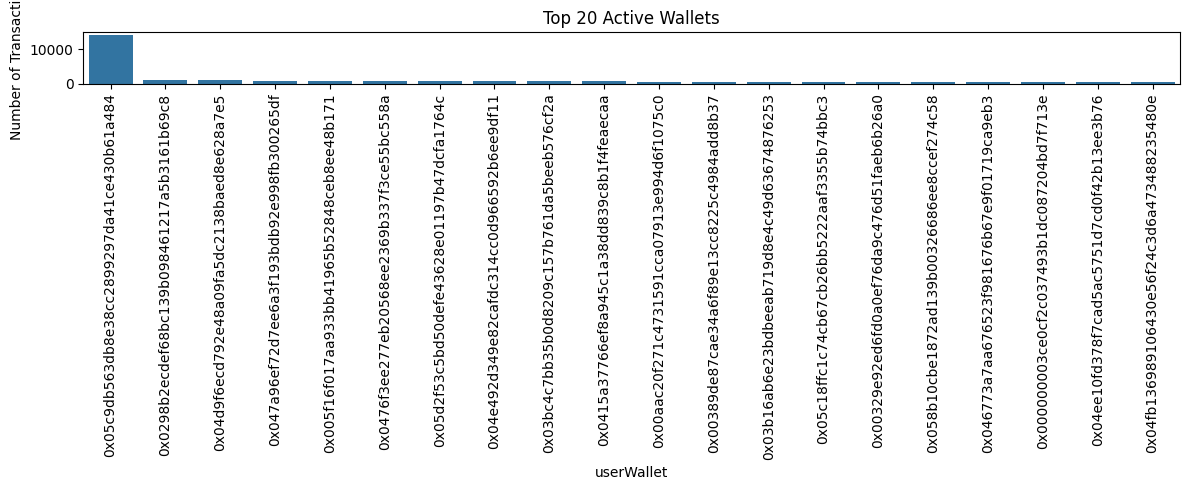

In [88]:
# Action Type Distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='actionType', order=df['actionType'].value_counts().index)
plt.title("Action Type Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Wallet activity
wallet_activity = df['userWallet'].value_counts().head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=wallet_activity.index, y=wallet_activity.values)
plt.title("Top 20 Active Wallets")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Feature Engineering

In [89]:
# Grouped feature engineering
wallet_groups = df.groupby('userWallet')

features = []

for wallet, group in wallet_groups:
    wallet_data = {
        'userWallet': wallet,
        'n_txns': len(group),
        'n_deposit': (group['actionType'] == 'Deposit').sum(),
        'n_borrow': (group['actionType'] == 'Borrow').sum(),
        'n_repay': (group['actionType'] == 'Repay').sum(),
        'n_redeem': (group['actionType'] == 'RedeemUnderlying').sum(),
        'n_liquidation': (group['actionType'] == 'LiquidationCall').sum(),
        'total_deposit_amount': group.loc[group['actionType'] == 'Deposit', 'amount'].sum(),
        'total_borrow_amount': group.loc[group['actionType'] == 'Borrow', 'amount'].sum(),
        'total_repay_amount': group.loc[group['actionType'] == 'Repay', 'amount'].sum(),
        'avg_txn_amount': group['amount'].mean(),
        'active_days': group['timestamp'].dt.date.nunique(),
        'asset_diversity': group['assetSymbol'].nunique()
    }
    features.append(wallet_data)

# Final feature DataFrame
wallet_features = pd.DataFrame(features)

wallet_features.set_index('userWallet', inplace=True)
wallet_features.head()


,n_txns,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_amount,total_borrow_amount,total_repay_amount,avg_txn_amount,active_days,asset_diversity
userWallet,,,,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2.000000e-09,0.0,0.000000e+00,2.000000e-09,1,1
0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,1.450000e+02,0.0,0.000000e+00,1.450000e+02,1,1
0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.000000e-03,0.0,0.000000e+00,2.500000e-03,2,1
0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000e+00,0.0,0.000000e+00,2.844292e-01,8,4
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,9.459366e+04,39460.0,7.002457e-08,4.348853e+02,104,6


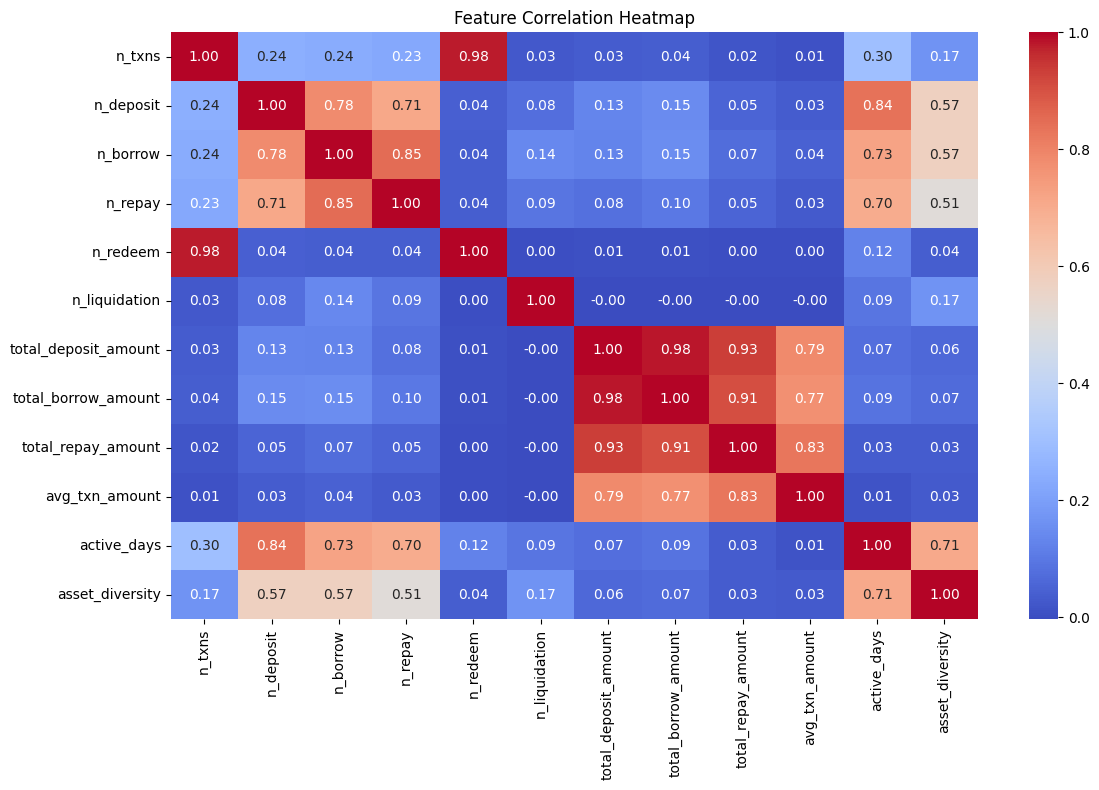

In [90]:
plt.figure(figsize=(12, 8))
sns.heatmap(wallet_features.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


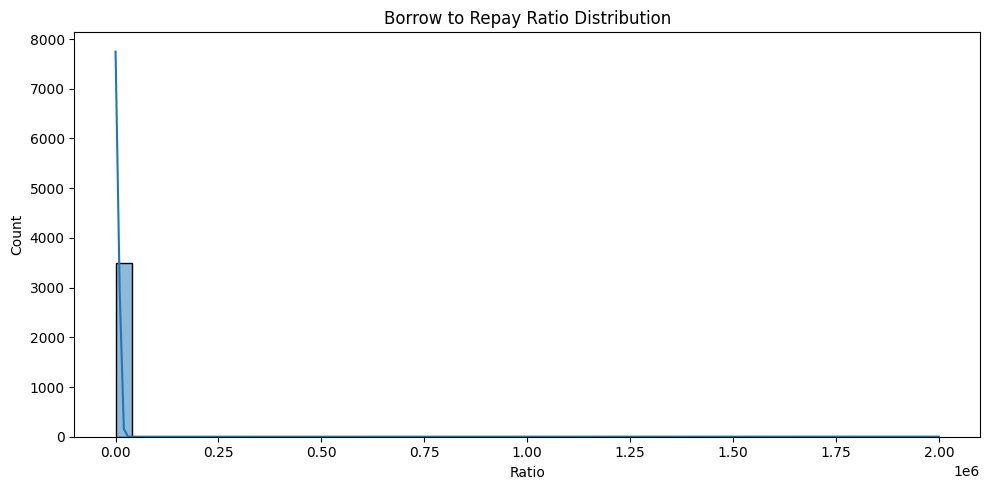

In [91]:
wallet_features['borrow_to_repay_ratio'] = wallet_features['total_repay_amount'] / (wallet_features['total_borrow_amount'] + 1e-6)

plt.figure(figsize=(10, 5))
sns.histplot(wallet_features['borrow_to_repay_ratio'], bins=50, kde=True)
plt.title("Borrow to Repay Ratio Distribution")
plt.xlabel("Ratio")
plt.tight_layout()
plt.show()

# Model Training

In [92]:
#Model Training

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fill NaNs (e.g. from borrow_to_repay_ratio) if not already done
wallet_features['borrow_to_repay_ratio'] = wallet_features['total_repay_amount'] / (wallet_features['total_borrow_amount'] + 1e-6)
wallet_features['borrow_to_repay_ratio'] = wallet_features['borrow_to_repay_ratio'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Select features for modeling
feature_cols = [
    'n_txns', 'n_deposit', 'n_borrow', 'n_repay', 'n_redeem', 'n_liquidation',
    'total_deposit_amount', 'total_borrow_amount', 'total_repay_amount',
    'avg_txn_amount', 'active_days', 'asset_diversity', 'borrow_to_repay_ratio'
]

In [93]:
# ✅ wallet_features DataFrame is ready
wallet_features.head()

,n_txns,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_amount,total_borrow_amount,total_repay_amount,avg_txn_amount,active_days,asset_diversity,borrow_to_repay_ratio
userWallet,,,,,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2.000000e-09,0.0,0.000000e+00,2.000000e-09,1,1,0.000000e+00
0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,1.450000e+02,0.0,0.000000e+00,1.450000e+02,1,1,0.000000e+00
0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.000000e-03,0.0,0.000000e+00,2.500000e-03,2,1,0.000000e+00
0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000e+00,0.0,0.000000e+00,2.844292e-01,8,4,0.000000e+00
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,9.459366e+04,39460.0,7.002457e-08,4.348853e+02,104,6,1.774571e-12


In [94]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

X = wallet_features.copy()

# Log scale heavy fields, clip outlier ratios
X['total_deposit_amount'] = np.log1p(X['total_deposit_amount'])
X['borrow_to_repay_ratio'] = np.clip(X['borrow_to_repay_ratio'], 0, 5)
X['borrow_to_repay_ratio'] = np.log1p(X['borrow_to_repay_ratio'])

features_for_scoring = [
    'n_repay', 'borrow_to_repay_ratio', 'active_days',
    'total_deposit_amount', 'n_liquidation'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[features_for_scoring])


In [95]:
# Weight each feature AFTER normalization
rule_score_raw = (
    1.5 * X_scaled[:, 0] +   # n_repay
    2.0 * X_scaled[:, 1] +   # borrow_to_repay_ratio
    1.0 * X_scaled[:, 2] +   # active_days
    0.5 * X_scaled[:, 3] -   # deposit amount
    2.0 * X_scaled[:, 4]     # n_liquidation
)

In [96]:
wallet_features['rule_score'] = MinMaxScaler().fit_transform(rule_score_raw.reshape(-1, 1)) * 1000
wallet_features['rule_score'] = wallet_features['rule_score'].round(2)

In [99]:
bins = [0,100,200,300,400,500,600,700,800,900,1000]
wallet_features['score_range'] = pd.cut(wallet_features['rule_score'], bins=bins)

# Optional: Display score stats
print(wallet_features['rule_score'].describe())
wallet_features['score_range'].value_counts().sort_index()

count    3497.000000
mean      580.923600
std        40.526936
min         0.000000
25%       562.380000
50%       564.330000
75%       579.860000
max      1000.000000
Name: rule_score, dtype: float64


score_range
(0, 100]          0
(100, 200]        1
(200, 300]        1
(300, 400]        3
(400, 500]        7
(500, 600]     2829
(600, 700]      598
(700, 800]       50
(800, 900]        5
(900, 1000]       2
Name: count, dtype: int64

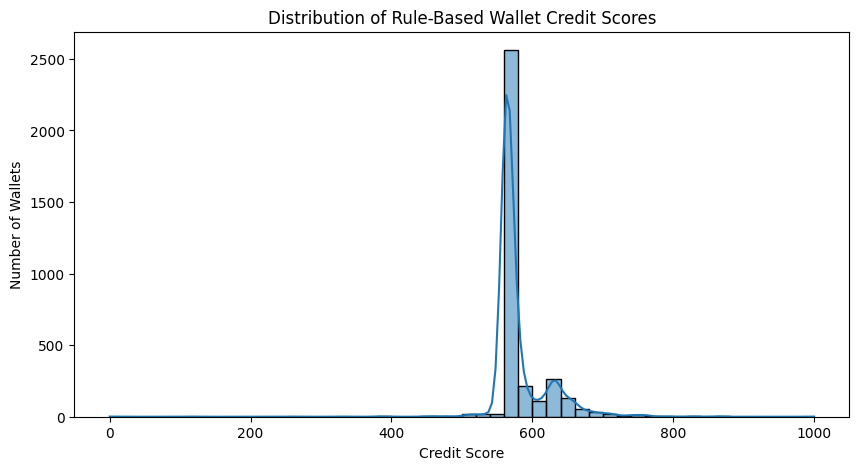

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(wallet_features['rule_score'], bins=50, kde=True)
plt.title('Distribution of Rule-Based Wallet Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.show()

In [ ]:
# Top 10 most trusted
wallet_features.sort_values('rule_score', ascending=False).head(10)

,n_txns,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_amount,total_borrow_amount,total_repay_amount,avg_txn_amount,active_days,asset_diversity,borrow_to_repay_ratio,rule_score,score_range
userWallet,,,,,,,,,,,,,,,
0x04d9f6ecd792e48a09fa5dc2138baed8e628a7e5,1089,411,178,291,209,0,1.052219e+04,5.065979e+03,4899.992757,25.939205,67,8,0.967235,1000.00,"(900, 1000]"
0x047a96ef72d7ee6a3f193bdb92e998fb300265df,820,179,200,207,234,0,2.429375e+04,1.517891e+05,151857.449352,441.806218,61,8,1.000450,905.34,"(900, 1000]"
0x03b16ab6e23bdbeeab719d8e4c49d63674876253,597,143,147,153,154,0,2.492910e+05,3.310640e+05,331193.027530,1944.057662,83,7,1.000390,866.10,"(800, 900]"
0x00aac20f271c4731591cca07913e994d6f1075c0,633,289,89,176,79,0,1.014584e+03,5.091632e+03,1392.786327,11.883212,99,8,0.273544,860.69,"(800, 900]"
0x04e492d349e82cafdc314cc0d966592b6ee9df11,675,244,183,149,99,0,1.034809e+05,1.750700e+04,16353.095047,239.739481,77,8,0.934089,853.19,"(800, 900]"
0x00329e92ed6fd0a0ef76da9c476d51faeb6b26a0,523,179,154,148,42,0,2.052358e+06,3.755628e+06,433843.321543,12594.375288,98,7,0.115518,828.01,"(800, 900]"
0x006f74448baead5563915255c8fbc12fd7f6a5df,298,8,142,142,6,0,5.274248e+02,8.386702e+05,758844.989960,5362.687778,63,7,0.904819,826.70,"(800, 900]"
0x05d2f53c5bd50defe43628e01197b47dcfa1764c,753,267,198,157,131,0,8.221518e+05,2.000200e+04,2.000259,1122.365312,60,8,0.000100,798.24,"(700, 800]"
0x04b5c5d08ddef275535c5a95a62f803fc1cd3dba,211,40,52,103,16,0,1.569496e+03,5.301234e+04,40082.840699,454.594493,71,8,0.756104,784.90,"(700, 800]"


In [ ]:
# Bottom 10 riskiest
wallet_features.sort_values('rule_score', ascending=True).head(10)

,n_txns,n_deposit,n_borrow,n_repay,n_redeem,n_liquidation,total_deposit_amount,total_borrow_amount,total_repay_amount,avg_txn_amount,active_days,asset_diversity,borrow_to_repay_ratio,rule_score,score_range
userWallet,,,,,,,,,,,,,,,
0x02a16f8df2b11b3a0c9f47cc5d705830792e3e6f,366,111,117,78,34,26,254.071434,1.751633e+03,1.392093e+03,10.117449,44,6,7.947402e-01,0.00,NaN
0x04426a58fdd02eb166b7c1a84ef390c4987ae1e0,93,17,31,9,19,17,5281.824309,3.200000e+03,3.422049e+02,117.558731,7,7,1.069390e-01,114.80,"(100.0, 200.0]"
0x04288d0b8bc6298a7cc26f367f42932d71c79d9a,33,11,9,0,2,11,1.991977,4.146226e+02,0.000000e+00,30.778994,11,6,0.000000e+00,260.28,"(200.0, 300.0]"
0x02eb2ee0867dc3dfaa3862d0cc86984b6aada907,37,12,9,2,4,10,2043.431044,1.235000e+03,5.491140e+02,126.379093,13,5,4.446267e-01,330.11,"(300.0, 400.0]"
0x051ba1cf67593ea9e697a1039c549cc94660c4b2,24,9,8,0,0,7,15496.100000,7.136000e+03,0.000000e+00,943.004167,7,4,0.000000e+00,381.06,"(300.0, 400.0]"
0x0256b3d533b384fd24bfef8f61491ceea5426b5e,75,31,18,10,8,8,27420.311188,9.666308e+03,1.224329e+03,510.840664,18,8,1.266594e-01,382.68,"(300.0, 400.0]"
0x04379cffc95575cff92a5884863a26600c0f3ddb,12,3,2,2,0,5,205.034000,5.000000e+01,6.305173e+00,21.778264,7,5,1.261034e-01,444.00,"(400.0, 500.0]"
0x02bcb5d5a59ec3350ec2bed6c7ffcd5d566d9574,14,6,4,0,0,4,0.153230,3.400469e-10,0.000000e+00,0.010945,4,5,0.000000e+00,451.70,"(400.0, 500.0]"
0x012fefa16a3baad884834385a0988378852d00bc,7,2,1,0,0,4,15.000000,1.128349e-11,0.000000e+00,2.142857,5,3,0.000000e+00,455.77,"(400.0, 500.0]"


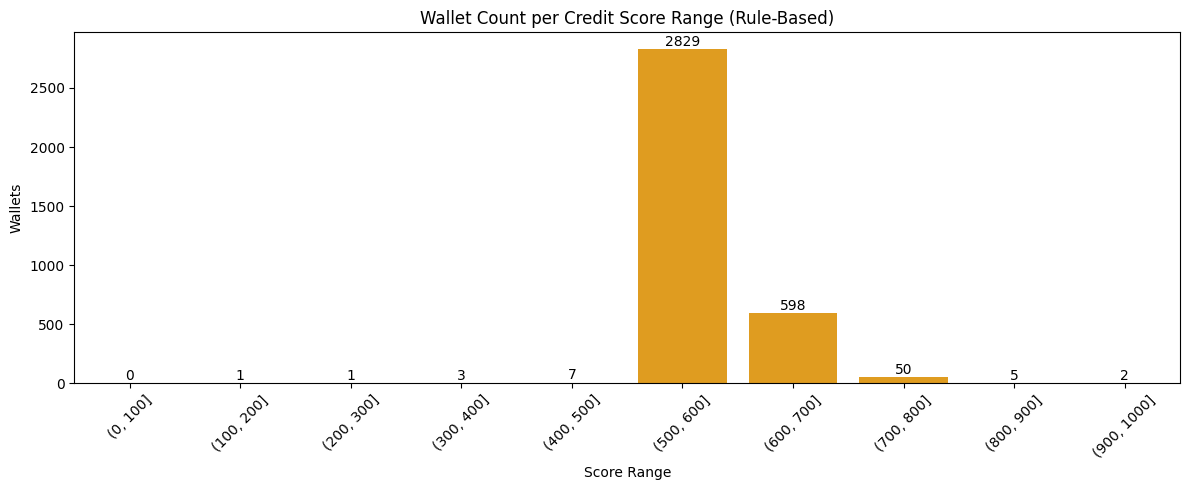

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define scoring buckets
wallet_features['score_range'] = pd.cut(wallet_features['rule_score'], bins=[0,100,200,300,400,500,600,700,800,900,1000])

# Count wallets in each bucket
bucket_counts = wallet_features['score_range'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=bucket_counts.index.astype(str), y=bucket_counts.values, color='orange')

# Annotate frequency on top of each bar
for i, value in enumerate(bucket_counts.values):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.title("Wallet Count per Credit Score Range (Rule-Based)")
plt.ylabel("Wallets")
plt.xlabel("Score Range")
plt.tight_layout()
plt.show()


In [104]:
print(bucket_counts)

score_range
(0, 100]          0
(100, 200]        1
(200, 300]        1
(300, 400]        3
(400, 500]        7
(500, 600]     2829
(600, 700]      598
(700, 800]       50
(800, 900]        5
(900, 1000]       2
Name: count, dtype: int64


## Feature Contribution 

<Axes: >

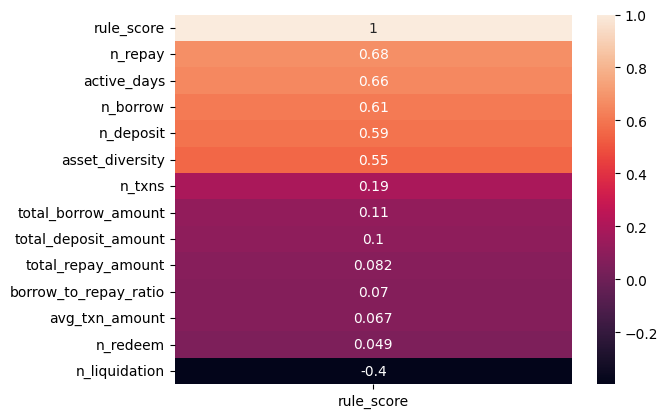

In [108]:
# Only include numeric columns
corr = wallet_features.corr(numeric_only=True)

# Visualize correlation of all features with 'rule_score'
sns.heatmap(corr[['rule_score']].sort_values(by='rule_score', ascending=False), annot=True)